In [14]:
import numpy as np
from cosmoTransitions import generic_potential_1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special

####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18

class model1(generic_potential_1.generic_potential):
    def init(self, ms = 50, theta = 0, muhs = 0, u = 100, mu3 = 0):
        self.Ndim = 2
        self.renormScaleSq = v2
        self.ms = ms
        self.theta = theta
        self.muhs = muhs
        self.u = u
        self.mu3 = mu3
        self.lamh = 1/(2*v2)*(mh**2*np.cos(self.theta)**2+self.ms**2*np.sin(self.theta)**2)
        #self.lams = 1/(2*self.u**2)*(mh**2*np.sin(self.theta)**2+self.ms**2*np.cos(self.theta)**2 + self.mu3*self.u + self.muhs*v**2/(2*self.u))
        self.lams = 1/(4*self.u**3)*(mh**2*self.u + ms**2*self.u + 2*self.u**2*self.mu3 + v**2*self.muhs - (mh**2-ms**2)*self.u*np.cos(2*self.theta))
        self.lammix = 1/(v*self.u)*(-(self.ms**2-mh**2)*np.sin(self.theta)*np.cos(self.theta) - self.muhs*v)
        self.muh2 = self.lamh*v2 + self.muhs*self.u + self.lammix/2*self.u**2
        self.mus2 = -self.mu3*self.u + self.lams*self.u**2 + self.muhs*v2/(2*self.u) + self.lammix/2*v2
        if abs(self.lamh)>2 and abs(self.lams)>2 and abs(self.lammix)>2:
            print("Couplings are non perturbative")
        
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])
    
    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -1/2*self.muh2*h**2 + 1/4*self.lamh*h**4 - 1/2*self.mus2*s**2 - 1/3*self.mu3*s**3 + 1/4*self.lams*s**4 + 1/2*self.muhs*h**2*s + 1/4*self.lammix*h**2*s**2
        return pot
    
    def boson_massSq(self, X, T):
        
        X = np.array(X)
        h, s = X[...,0], X[...,1]

        #####Scalar thermal masses##
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + 1/4*mh**2/v**2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)
     
        ##Scalar mass matrix##
        a= -self.muh2 + 3*self.lamh*h**2 + self.muhs*s + 1/2*self.lammix*s**2 + Pi_h
        b= -self.mus2 - 2*self.mu3*s + 3*self.lams*s**2 + 1/2*self.lammix*h**2 + Pi_s
        cc=h*s*self.lammix + self.muhs*h
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B
        
        ####Gauge boson masses
        mW = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZ=Ag+Bg
        mPh=Ag-Bg

        M = np.array([m1,m2,mW,mZ])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,6,3])


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5])
        
        return M, dof, c, Mphys
    
    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=h**2/2
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))
        
        dof = np.array([12])
        return M, dof, Mphys
    

    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.
        v = v2**.5
        return [np.array([v,self.u]), np.array([-v,-self.u]),np.array([v,-self.u]),np.array([-v,self.u])]
    


(1.0, 9000.0)

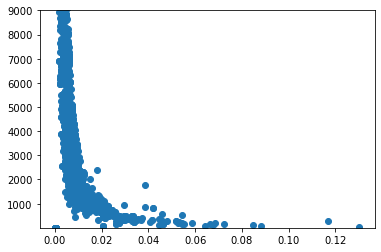

In [13]:
df=pd.read_csv("filtered_scan.csv",index_col=[0])
plt.scatter(df["alpha"],df["beta/H"])
plt.ylim(1,9000)

In [2]:
m=model1(ms = 270.0001, theta =0.00001, muhs = 0, u = 100, mu3 =2000)
#m=model1(ms = 38.0001, theta =0.0001, muhs = 0, u = 290, mu3 =10)
bosons=m.boson_massSq([v,m.u],0)
bosons

(array([72900.05400001, 15625.        ,  6222.926288  ,  8008.91414157]),
 array([1, 1, 6, 3]),
 array([1.5, 1.5, 1.5, 1.5]),
 array([72900.05400001, 15625.        ,  6222.926288  ,  8008.91414157]))

In [3]:
m.getPhases(tracingArgs={"dtstart":1e-2, "tjump":1e-2})

Tracing phase starting at x = [2.45998168e+02 1.41100750e-01] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
..............................................................................................................................................................................
Tracing phase starting at x = [-7.61056534e-06  7.91761571e+01] ; t = 179.24474870847015
Tracing minimum down
traceMinimum t0 = 179.245
.............................
Tracing minimum up
traceMinimum t0 = 179.245
...........................................................................................................................................
Tracing phase starting at x = [246.00000073 100.00000135] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................................................................


{0: Phase(key=0, X=[[246 0.1411], ..., [13.43 21.69]], T=[0, ..., 169.2], dXdT=[[-0 -0], ..., [-41.49 0.5823]],
 1: Phase(key=1, X=[[-0.01341 83.35], ..., [-0.001107 48.88]], T=[169.5, ..., 1000], dXdT=[[0.08034 -0.2468], ..., [-0.000124 6.661e-05]],
 2: Phase(key=2, X=[[246 100], ..., [19.28 83.53]], T=[0, ..., 169.1], dXdT=[[-0 -0], ..., [-27.12 -0.2444]]}

In [4]:
m.findAllTransitions()

Tunneling from phase 0 to phase 2 at T=0
high_vev = [2.45998167e+02 1.41099491e-01]
low_vev = [246.00000073 100.00000135]
Path deformation converged. 1 steps. fRatio = 3.16959e-02
Tunneling from phase 0 to phase 2 at T=169.0566
high_vev = [19.26504853 21.55918248]
low_vev = [19.2846656  83.53161781]
Path deformation converged. 1 steps. fRatio = 3.17269e-04
Tunneling from phase 0 to phase 2 at T=169.0561
high_vev = [19.27895723 21.55880058]
low_vev = [19.29839996 83.53180904]
Path deformation converged. 1 steps. fRatio = 3.14443e-04
Tunneling from phase 0 to phase 2 at T=84.52807
high_vev = [231.80926204   1.123687  ]
low_vev = [231.81128122  98.80208202]
Path deformation converged. 1 steps. fRatio = 3.85731e-02
Tunneling from phase 0 to phase 2 at T=82.05393
high_vev = [233.25221004   0.97648784]
low_vev = [233.25421323  98.93937787]
Path deformation converged. 1 steps. fRatio = 3.73798e-02
Tunneling from phase 0 to phase 2 at T=82.95552
high_vev = [232.73798249   1.02860149]
low_vev =

[{'Tnuc': 169.37657618005028,
  'low_vev': array([-1.34126513e-02,  8.33520539e+01]),
  'high_vev': array([-1.34126513e-02,  8.33520539e+01]),
  'low_phase': 0,
  'high_phase': 1,
  'action': 0.0,
  'instanton': None,
  'trantype': 2,
  'crit_trans': {'Tcrit': 169.37657618005028,
   'low_vev': array([-1.34126513e-02,  8.33520539e+01]),
   'high_vev': array([-1.34126513e-02,  8.33520539e+01]),
   'low_phase': 0,
   'high_phase': 1,
   'action': 0.0,
   'instanton': None,
   'trantype': 2,
   'Delta_rho': 0.0},
  'Delta_rho': 0.0,
  'Delta_p': 0.0},
 {'low_vev': array([232.5965034 ,  98.87700038]),
  'high_vev': array([232.59449356,   1.04321321]),
  'Tnuc': 83.20305008851636,
  'low_phase': 2,
  'high_phase': 0,
  'instanton': fullTunneling_rval(profile1D=Profile1D(R=array([0.        , 0.00047941, 0.00095724, 0.00143348, 0.00190814,
         0.00238121, 0.00285269, 0.00332259, 0.0037909 , 0.00425763,
         0.00472277, 0.00518632, 0.00564829, 0.00610867, 0.00656747,
         0.0070246

In [5]:
m.TnTrans[-1]

{'low_vev': array([232.5965034 ,  98.87700038]),
 'high_vev': array([232.59449356,   1.04321321]),
 'Tnuc': 83.20305008851636,
 'low_phase': 2,
 'high_phase': 0,
 'instanton': fullTunneling_rval(profile1D=Profile1D(R=array([0.        , 0.00047941, 0.00095724, 0.00143348, 0.00190814,
        0.00238121, 0.00285269, 0.00332259, 0.0037909 , 0.00425763,
        0.00472277, 0.00518632, 0.00564829, 0.00610867, 0.00656747,
        0.00702468, 0.0074803 , 0.00793434, 0.00838679, 0.00883766,
        0.00928694, 0.00973463, 0.01018074, 0.01062526, 0.0110682 ,
        0.01150955, 0.01194931, 0.01238749, 0.01282408, 0.01325909,
        0.01369251, 0.01412434, 0.01455459, 0.01498325, 0.01541033,
        0.01583582, 0.01625973, 0.01668205, 0.01710278, 0.01752193,
        0.01793949, 0.01835546, 0.01876985, 0.01918265, 0.01959387,
        0.0200035 , 0.02041155, 0.020818  , 0.02122288, 0.02162616,
        0.02202787, 0.02242798, 0.02282651, 0.02322345, 0.02361881,
        0.02401258, 0.02440477, 0.02

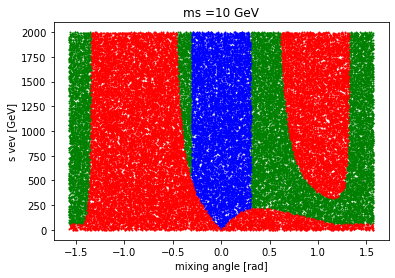

In [6]:
p_in_th = []
p_in_u = []
p_exp_u = []
p_exp_th = []
p_out_th = []
p_out_u = []
lammix_max = 0
theta_max = 0
u_max = 0
Gamma_tot = 0.013
msi = 10
for i in range(50000):
    thi = random.uniform(-np.pi/2,np.pi/2)
    ui = random.uniform(0,2000)
    m=model1(ms = msi, theta = thi, muhs = 0, u = ui, mu3 = 0)
    beta_s = (1-4*m.ms**2/mh**2)**0.5
    Lambda_HSS = (mh**2+2*m.ms**2)*(-np.cos(m.theta)+np.sin(m.theta)*m.u/v)*np.sin(2*m.theta)/(4*m.u)
    Gamma = Lambda_HSS**2*beta_s/(32*np.pi*mh)
    #ch = 1/48*(9*g**2+3*g1**2+12+24*m.lamh+2*m.lammix)
    #cs = 1/12*(2*m.lammix+3*m.lams)
    if Gamma/(Gamma_tot+Gamma) < 0.24 and m.lammix > -2*(m.lamh*m.lams)**0.5 and m.lams > 0 and m.lamh > 0 and np.abs(m.lamh)<2*np.pi/3 and np.abs(m.lams)<2*np.pi/3 and np.abs(m.lammix)<2*np.pi/3: 
        #if m.lammix > lammix_max: 
        #    lammix_max = m.lammix
        #    theta_max = m.theta
        #    u_max = m.u
        if abs(np.sin(m.theta))<0.3:
            p_exp_th.append(thi)
            p_exp_u.append(ui)
        else:
            p_in_th.append(thi)
            p_in_u.append(ui)
    else:
        p_out_th.append(thi)
        p_out_u.append(ui)
plt.scatter(p_in_th,p_in_u, c = 'green', s = 1)
plt.scatter(p_exp_th,p_exp_u, c = 'blue', s = 1)
plt.scatter(p_out_th,p_out_u, c = 'red', s = 1)
plt.xlabel('mixing angle [rad]')
plt.ylabel('s vev [GeV]')
plt.title("ms =%0.f" %msi+ " GeV")
plt.show()

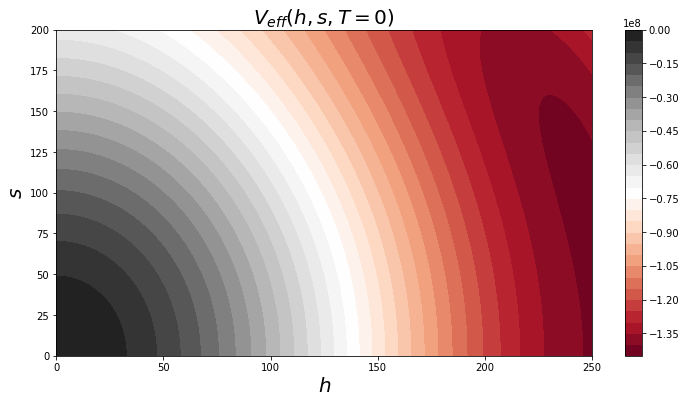

In [8]:

clevs=100
myN = 30
Temp=0
box=(-0,250,-0,m.u+100)
xmin,xmax,ymin,ymax=box
x=np.linspace(xmin,xmax,clevs)
y=np.linspace(ymin,ymax,clevs)
X,Y=np.meshgrid(x,y)
Z_V=[]
for i in x:
    Z_V_row=[]
    for j in y:
        Z_V_row.append([m.Vtot([i,j],Temp)])
    Z_V.append(Z_V_row)
Z_V=np.array(Z_V).T[0]


fig, ax1 = plt.subplots(1,1,figsize=(12,6))
ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp + ")",size=20)
ax1.set_xlabel('$h$',size=20)
ax1.set_ylabel('$s$',size=20)
cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
fig.colorbar(cf1, ax=ax1)

plt.show()

In [15]:
df=pd.read_csv("newNStab_vT15.csv",sep = '\t')


In [16]:
df=pd.read_csv("newNStab_vT15.csv",sep = '\t')
df=df[['mH', 'α', 's0', 'μ3', 'lS', 'μϕ2', 'μS2', 'lϕ', 'lϕS', 'μϕS']]
df.head(10)

,mH,α,s0,μ3,lS,μϕ2,μS2,lϕ,lϕS,μϕS
0,474.733632,0.107207,59.8689,446.2050,8.866822,7.361289e+02,50942.367453,0.148963,7.654850,-367.666070
1,474.733632,0.107207,59.8689,446.2050,8.866822,7.361289e+02,50942.367453,0.148963,7.654850,-367.666070
2,545.029488,0.111539,-724.2650,94.1123,0.044474,-1.583119e+06,86201.147564,0.157915,5.723355,4271.657066
3,474.733632,0.107207,59.8689,446.2050,8.866822,7.361289e+02,50942.367453,0.148963,7.654850,-367.666070
4,545.029488,0.111539,-724.2650,94.1123,0.044474,-1.583119e+06,86201.147564,0.157915,5.723355,4271.657066
5,639.160606,0.118356,-571.8860,280.4070,0.037657,-1.219484e+06,162761.125147,0.174342,6.867673,4114.631559
6,474.733632,0.107207,59.8689,446.2050,8.866822,7.361289e+02,50942.367453,0.148963,7.654850,-367.666070
7,545.029488,0.111539,-724.2650,94.1123,0.044474,-1.583119e+06,86201.147564,0.157915,5.723355,4271.657066
8,760.658986,0.065464,-848.8130,302.1490,0.016692,-3.568766e+06,263165.268217,0.149029,9.579973,8280.865197
9,567.204934,0.102577,-30.5094,-116.3670,0.002263,2.556006e+03,-129335.189037,0.155628,6.476060,324.206831


In [17]:
i=0
m=model1(ms = df.iloc[i].mH, theta =df.iloc[i].α, muhs = df.iloc[i]["μϕS"], u = df.iloc[i].s0, mu3 =df.iloc[i]["μ3"])
m.lamh-df.iloc[i]["lϕ"],m.lams-df.iloc[i]["lS"],

(-8.161591104136057e-05, -1.598568587724003e-05)

In [18]:
row_list=[]
for i in range(len(df)):
    m=model1(ms = df.iloc[i].mH, theta =df.iloc[i].α, muhs = df.iloc[i]["μϕS"], u = df.iloc[i].s0, mu3 =df.iloc[i]["μ3"])
    if abs(m.lams-df.iloc[i]["lS"])>=1e-2:
        row_list.append(i)
        
        

In [14]:
len(np.array(row_list))

0